In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dist_model, get_simple_dense_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, save_object
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Train MLP - multiple levels

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
model_dir = 'models/uncertainty/train_multiple_levels/run4/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [8]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

# Set initial batch size
warmup_batch_size = {level: 64 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 256 if level <= 9 else 25000 for level in range(1, 1+12)}

# select which model function was used to build the model
models_base = {
#     1: get_direct_dist_model(inp_shape=input_shapes[1], num_nodes=2, clear_session=False),
#     2: get_direct_dist_model(inp_shape=input_shapes[2], num_nodes=2, clear_session=False),
#     3: get_direct_dist_model(inp_shape=input_shapes[3], num_nodes=2, clear_session=False),
#     4: get_direct_dist_model(inp_shape=input_shapes[4], num_nodes=6, clear_session=False),
#     5: get_direct_dist_model(inp_shape=input_shapes[5], num_nodes=8, clear_session=False),
#     6: get_direct_dist_model(inp_shape=input_shapes[6], num_nodes=8, clear_session=False),
    7: get_direct_dist_model(inp_shape=input_shapes[7], num_nodes=8, clear_session=False),
    8: get_direct_dist_model(inp_shape=input_shapes[8], num_nodes=9, clear_session=False),
    9: get_direct_dist_model(inp_shape=input_shapes[9], num_nodes=16, clear_session=False),
}

## Perform training scheme

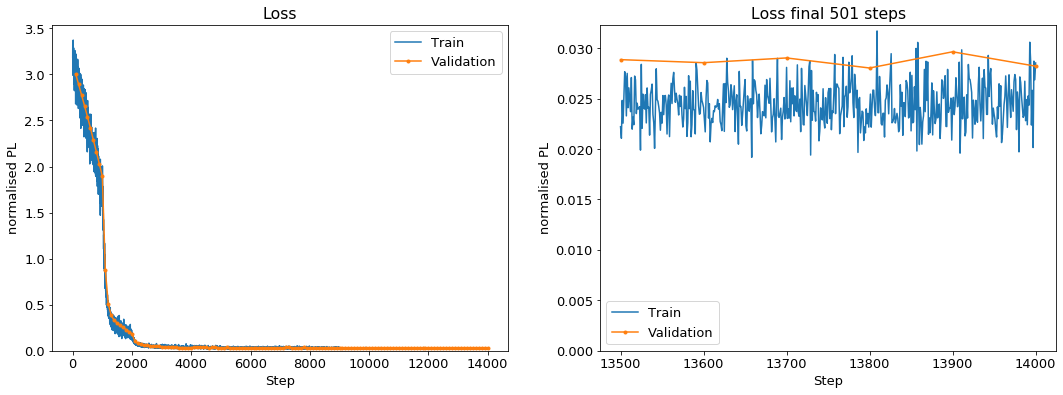

100/100 [==============================] - 4s 38ms/step - loss: 0.0248 - q0_loss: 2.2540e-04 - q1_loss: 8.2230e-04 - q2_loss: 0.0034 - q3_loss: 0.0044 - q4_loss: 0.0057 - q5_loss: 0.0048 - q6_loss: 0.0039 - q7_loss: 0.0011 - q8_loss: 3.4154e-04 - val_loss: 0.0282 - val_q0_loss: 2.0006e-04 - val_q1_loss: 8.2534e-04 - val_q2_loss: 0.0037 - val_q3_loss: 0.0050 - val_q4_loss: 0.0068 - val_q5_loss: 0.0057 - val_q6_loss: 0.0045 - val_q7_loss: 0.0012 - val_q8_loss: 3.2470e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.1469006381946226, 'WSPL': 0.1469006381946226}


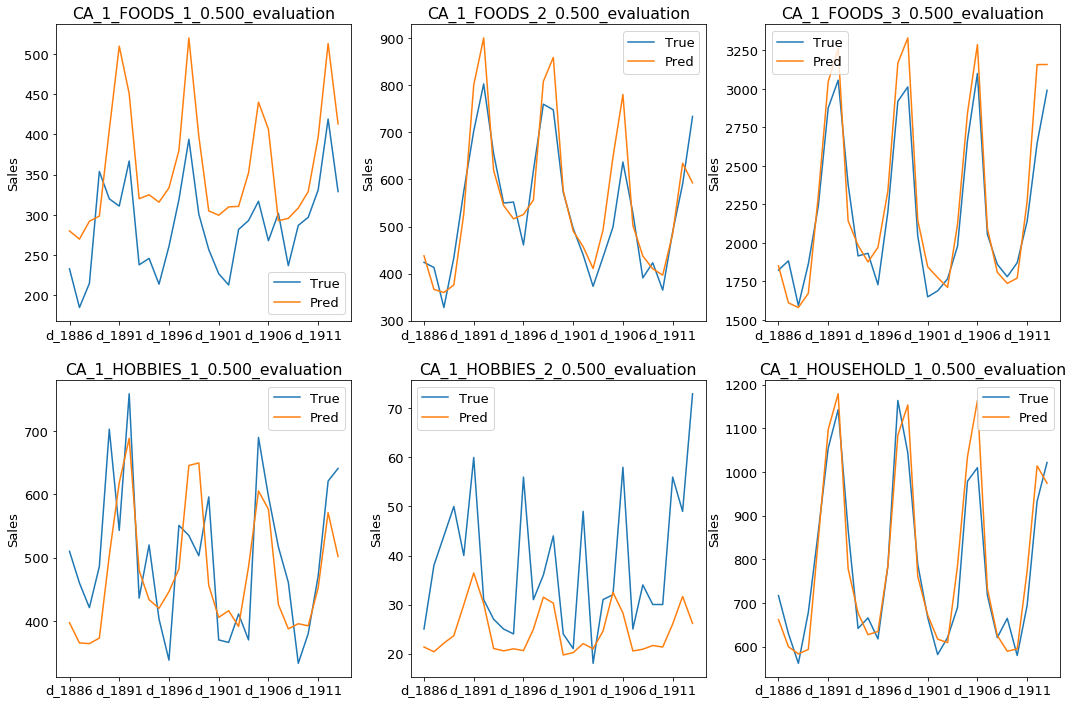

In [9]:
logger_list = []
part1_metrics = []
part2_metrics = []
part3_metrics = []

for level, model in models_base.items():
    # select model
    model = models_base[level]

    # train model
    warmup_lr_list = [1e-5, 1e-4, 1e-3, # save part 1
                      2e-3, 4e-3, 1e-3] # save part 2
    finetune_lr_list = [2e-3, 3e-3, 1e-3, 3e-4, 1e-4]
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list)
    
    # save metrics
    logger_list.append(logger); part1_metrics.append(metrics1); 
    part2_metrics.append(metrics2); part3_metrics.append(metrics3)

## Save results

In [10]:
part1_metrics

[{7: 0.12915867548849616, 'WSPL': 0.12915867548849616},
 {8: 0.13071365648357142, 'WSPL': 0.13071365648357142},
 {9: 0.15326318922263407, 'WSPL': 0.15326318922263407}]

In [11]:
part2_metrics

[{7: 0.12296068151614327, 'WSPL': 0.12296068151614327},
 {8: 0.13620224347974963, 'WSPL': 0.13620224347974963},
 {9: 0.14816844288974101, 'WSPL': 0.14816844288974101}]

In [12]:
part3_metrics

[{7: 0.12596799923682436, 'WSPL': 0.12596799923682436},
 {8: 0.13408692381692564, 'WSPL': 0.13408692381692564},
 {9: 0.1469006381946226, 'WSPL': 0.1469006381946226}]

In [13]:
for i, metrics in enumerate([part1_metrics, part2_metrics, part3_metrics]):
    save_object(metrics, model_dir + "metrics_ref_part{}.pickle".format(i+1))

for i, logger in enumerate(logger_list):
    save_object(logger.train_metrics, model_dir + "metrics_train_level{}.pickle".format(i+1))
    save_object(logger.val_metrics, model_dir + "metrics_val_level{}.pickle".format(i+1))

## Results

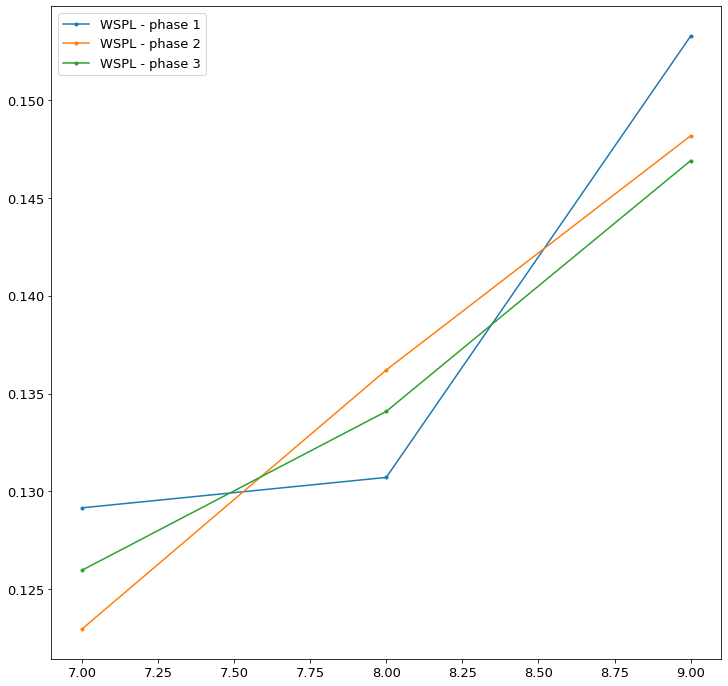

In [14]:
part1_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part1_metrics}
part2_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part2_metrics}
part3_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part3_metrics}

f, ax = plt.subplots(1, 1, figsize=(12, 12))

for i, metrics in enumerate([part1_WSPL, part2_WSPL, part3_WSPL]):
    ax.plot(list(metrics.keys()), list(metrics.values()), '.-', label="WSPL - phase {}".format(i+1))
ax.legend()
plt.show()

Level 7


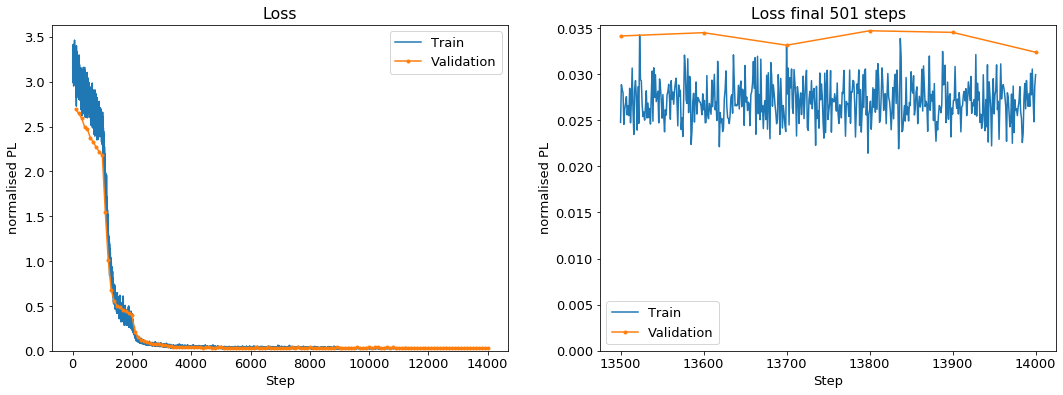

Level 8


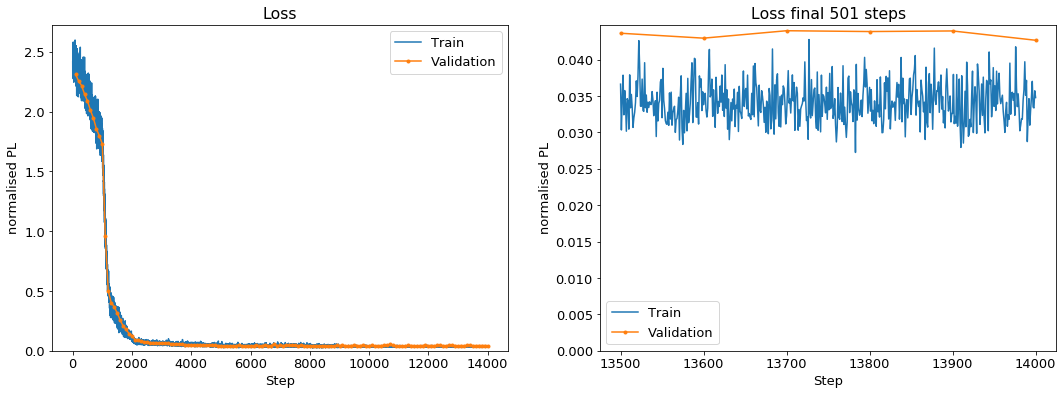

Level 9


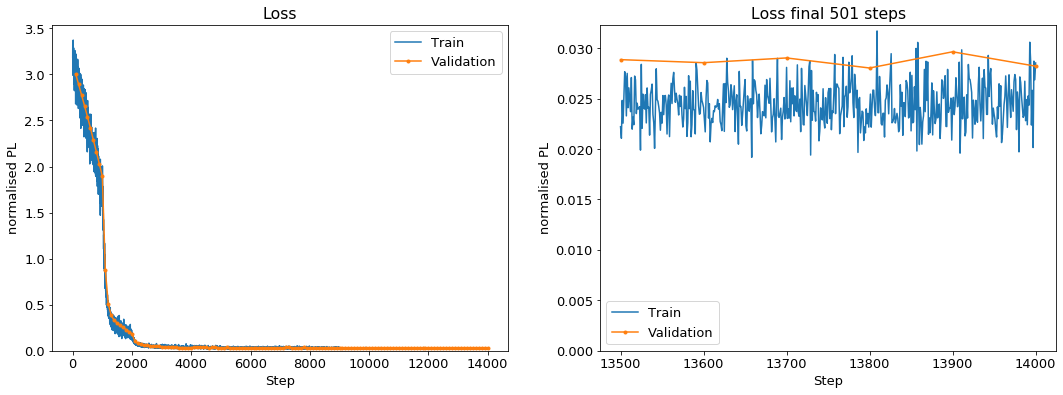

In [16]:
for i, logger in enumerate(logger_list):
    print("Level {}".format(i+7))
    logger.plot(clear=False)